<a href="https://colab.research.google.com/github/atharvadesai1/BE-Project-Codes/blob/main/liver_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/liver_segmentation_dataset.zip" -d "/content/dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/liver_segmentation_dataset.zip
replace /content/dataset/segmentations/segmentation-0.nii? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/dataset/segmentations/segmentation-0.nii  
  inflating: /content/dataset/segmentations/segmentation-1.nii  
  inflating: /content/dataset/segmentations/segmentation-10.nii  
  inflating: /content/dataset/segmentations/segmentation-100.nii  
  inflating: /content/dataset/segmentations/segmentation-101.nii  
  inflating: /content/dataset/segmentations/segmentation-102.nii  
  inflating: /content/dataset/segmentations/segmentation-103.nii  
  inflating: /content/dataset/segmentations/segmentation-104.nii  
  inflating: /content/dataset/segmentations/segmentation-105.nii  
  inflating: /content/dataset/segmentations/segmentation-106.nii  
  inflating: /content/dataset/segmentations

In [31]:
!pip install nibabel lime scikit-image shap
!pip install -q tensorflow==2.12.0

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 2.0.2 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.
orbax-checkpoint 0.11.13 requires jax>=0.5.0, but you have jax 0.4.30 which is incompatible.
flax 0.10.6 requires jax>=0.5.1, but you have jax 0.4.30 which is incompati

In [44]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import nibabel as nib
import glob
from tqdm import tqdm
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [45]:
def load_nifti_file(filepath):
    """Load a NIfTI file and return its data as numpy array"""
    scan = nib.load(filepath)
    data = scan.get_fdata()
    return data

def load_dataset(base_dir):
    """Load CT scans and corresponding masks with proper file matching"""
    ct_scans = []
    masks = []

    # Get all segmentation files first
    seg_files = sorted(glob.glob(os.path.join(base_dir, "segmentations", "*.nii*")))

    # Create a dictionary of available masks
    mask_dict = {os.path.basename(f): f for f in seg_files}

    # Search through all volume directories
    volume_dirs = sorted(glob.glob(os.path.join(base_dir, "volume_pt*")))

    for vol_dir in volume_dirs:
        ct_files = sorted(glob.glob(os.path.join(vol_dir, "*.nii*")))

        for ct_file in ct_files:
            # Try multiple naming patterns to find matching mask
            ct_filename = os.path.basename(ct_file)

            # Pattern 1: Direct match (volume-X.nii -> segmentation-X.nii)
            mask_file1 = os.path.join(base_dir, "segmentations", ct_filename.replace("volume", "segmentation"))

            # Pattern 2: Handle cases where filenames might be different
            # Extract number from filename (e.g., volume-0.nii -> 0)
            try:
                vol_num = ct_filename.split('-')[1].split('.')[0]
                mask_file2 = os.path.join(base_dir, "segmentations", f"segmentation-{vol_num}.nii")
            except:
                mask_file2 = ""

            # Check which pattern exists
            mask_file = None
            if os.path.exists(mask_file1):
                mask_file = mask_file1
            elif os.path.exists(mask_file2):
                mask_file = mask_file2
            elif ct_filename in mask_dict:
                mask_file = mask_dict[ct_filename]

            if mask_file and os.path.exists(mask_file):
                ct_scans.append(ct_file)
                masks.append(mask_file)
            else:
                print(f"Warning: No mask found for {ct_file}")

    return ct_scans, masks

In [46]:
# Load dataset (point to the root folder containing all your subfolders)
base_dir = "/content/dataset"  # Update with your actual path
ct_scans, masks = load_dataset(base_dir)

print(f"Found {len(ct_scans)} CT scans and {len(masks)} corresponding masks")

# Verify some samples
if len(ct_scans) > 0:
    print("\nSample CT scan:", ct_scans[0])
    print("Corresponding mask:", masks[0])

Found 51 CT scans and 51 corresponding masks

Sample CT scan: /content/dataset/volume_pt1/volume-0.nii
Corresponding mask: /content/dataset/segmentations/segmentation-0.nii


In [47]:
def preprocess_image(image, target_size=(256, 256)):
    """Normalize and resize CT scan slices"""
    # Normalize to [0, 1] range
    image = image.astype(np.float32)
    image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)
    # Resize
    image = cv2.resize(image, target_size)
    # Expand dimensions for model input
    return np.expand_dims(image, axis=-1)

def preprocess_mask(mask, target_size=(256, 256)):
    """Resize and binarize mask"""
    mask = cv2.resize(mask, target_size)
    mask = (mask > 0).astype(np.float32)  # Assuming 0 is background, >0 is tumor
    return np.expand_dims(mask, axis=-1)

In [48]:
class LiverTumorDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, ct_paths, mask_paths, batch_size=8, target_size=(256, 256), shuffle=True):
        self.ct_paths = ct_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.ct_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        ct_paths = [self.ct_paths[k] for k in indexes]
        mask_paths = [self.mask_paths[k] for k in indexes]

        X = np.zeros((self.batch_size, *self.target_size, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.target_size, 1), dtype=np.float32)

        for i, (ct_path, mask_path) in enumerate(zip(ct_paths, mask_paths)):
            # Load NIfTI files
            ct_data = load_nifti_file(ct_path)
            mask_data = load_nifti_file(mask_path)

            # For 3D volumes, we'll use the middle slice
            if len(ct_data.shape) == 3:
                mid_slice = ct_data.shape[2] // 2
                ct_slice = ct_data[:, :, mid_slice]
                mask_slice = mask_data[:, :, mid_slice]
            else:  # Handle 2D slices directly
                ct_slice = ct_data
                mask_slice = mask_data

            X[i,] = preprocess_image(ct_slice, self.target_size)
            y[i,] = preprocess_mask(mask_slice, self.target_size)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ct_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [49]:
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Downsample
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Upsample
    up5 = UpSampling2D(size=(2, 2))(conv4)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [50]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [53]:
# Verify we have data
if len(ct_scans) == 0:
    raise ValueError("No matching CT scans and masks found! Check your dataset structure.")
if len(masks) == 0:
    raise ValueError("No masks found! Check your dataset paths.")

# Split data
train_ct, val_ct, train_mask, val_mask = train_test_split(
    ct_scans, masks, test_size=0.2, random_state=42)

# Create data generators
train_gen = LiverTumorDataGenerator(train_ct, train_mask)
val_gen = LiverTumorDataGenerator(val_ct, val_mask)

# Create model
model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=dice_loss,
              metrics=[dice_coef, 'binary_accuracy'])

# Callbacks
callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_dice_coef', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_dice_coef', patience=10, restore_best_weights=True, mode='max'), # Added mode='max'
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

# Save final model
model.save('liver_tumor_segmentation.h5')
print("Model saved as liver_tumor_segmentation.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/50


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - binary_accuracy: 0.8937 - dice_coef: 0.0779 - loss: 0.9221 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


5/5 ━━━━━━━━━━━━━━━━━━━━ 109s 19s/step - binary_accuracy: 0.8737 - dice_coef: 0.0784 - loss: 0.9216 - val_binary_accuracy: 0.4834 - val_dice_coef: 0.1086 - val_loss: 0.8914 - learning_rate: 1.0000e-04
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 89s 19s/step - binary_accuracy: 0.4710 - dice_coef: 0.0916 - loss: 0.9084 - val_binary_accuracy: 0.4912 - val_dice_coef: 0.0989 - val_loss: 0.9011 - learning_rate: 1.0000e-04
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 96s 21s/step - binary_accuracy: 0.4651 - dice_coef: 0.0895 - loss: 0.9105 - val_binary_accuracy: 0.4521 - val_dice_coef: 0.0993 - val_loss: 0.9007 - learning_rate: 1.0000e-04
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 89s 18s/step - binary_accuracy: 0.4363 - dice_coef: 0.0785 - loss: 0.9215 - val_binary_accuracy: 0.4917 - val_dice_coef: 0.1072 - val_loss: 0.8928 - learning_rate: 1.0000e-04
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 90s 17s/step - binary_accuracy: 0.4773 - dice_coef: 0.0937 - loss: 0.9063 - val_binary_accuracy: 0.9501 - val_dice_coef: 0.1040 - 

5/5 ━━━━━━━━━━━━━━━━━━━━ 85s 20s/step - binary_accuracy: 0.3389 - dice_coef: 0.1210 - loss: 0.8790 - val_binary_accuracy: 0.4410 - val_dice_coef: 0.1257 - val_loss: 0.8743 - learning_rate: 2.0000e-05
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - binary_accuracy: 0.4654 - dice_coef: 0.1001 - loss: 0.8999 

5/5 ━━━━━━━━━━━━━━━━━━━━ 87s 19s/step - binary_accuracy: 0.4627 - dice_coef: 0.1031 - loss: 0.8969 - val_binary_accuracy: 0.5130 - val_dice_coef: 0.1565 - val_loss: 0.8435 - learning_rate: 2.0000e-05
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 89s 18s/step - binary_accuracy: 0.5935 - dice_coef: 0.1325 - loss: 0.8675 - val_binary_accuracy: 0.9640 - val_dice_coef: 0.1350 - val_loss: 0.8650 - learning_rate: 2.0000e-05
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - binary_accuracy: 0.7851 - dice_coef: 0.1966 - loss: 0.8034 

5/5 ━━━━━━━━━━━━━━━━━━━━ 93s 20s/step - binary_accuracy: 0.7707 - dice_coef: 0.1917 - loss: 0.8083 - val_binary_accuracy: 0.7374 - val_dice_coef: 0.1868 - val_loss: 0.8132 - learning_rate: 2.0000e-05
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - binary_accuracy: 0.7508 - dice_coef: 0.1940 - loss: 0.8060 

5/5 ━━━━━━━━━━━━━━━━━━━━ 95s 19s/step - binary_accuracy: 0.7653 - dice_coef: 0.1952 - loss: 0.8048 - val_binary_accuracy: 0.7975 - val_dice_coef: 0.2819 - val_loss: 0.7181 - learning_rate: 2.0000e-05
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 92s 18s/step - binary_accuracy: 0.6988 - dice_coef: 0.2284 - loss: 0.7716 - val_binary_accuracy: 0.7548 - val_dice_coef: 0.2438 - val_loss: 0.7562 - learning_rate: 2.0000e-05
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 92s 20s/step - binary_accuracy: 0.7443 - dice_coef: 0.1967 - loss: 0.8033 - val_binary_accuracy: 0.9567 - val_dice_coef: 0.1646 - val_loss: 0.8354 - learning_rate: 2.0000e-05
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 137s 18s/step - binary_accuracy: 0.8387 - dice_coef: 0.2527 - loss: 0.7473 - val_binary_accuracy: 0.6595 - val_dice_coef: 0.2058 - val_loss: 0.7942 - learning_rate: 2.0000e-05
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 95s 19s/step - binary_accuracy: 0.6007 - dice_coef: 0.1678 - loss: 0.8322 - val_binary_accuracy: 0.6072 - val_dice_coef: 0.209

5/5 ━━━━━━━━━━━━━━━━━━━━ 145s 20s/step - binary_accuracy: 0.7065 - dice_coef: 0.2094 - loss: 0.7906 - val_binary_accuracy: 0.8504 - val_dice_coef: 0.3527 - val_loss: 0.6473 - learning_rate: 4.0000e-06
Epoch 20/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 91s 17s/step - binary_accuracy: 0.8354 - dice_coef: 0.3086 - loss: 0.6914 - val_binary_accuracy: 0.9161 - val_dice_coef: 0.2931 - val_loss: 0.7069 - learning_rate: 4.0000e-06
Epoch 21/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - binary_accuracy: 0.8971 - dice_coef: 0.3215 - loss: 0.6785 

5/5 ━━━━━━━━━━━━━━━━━━━━ 89s 18s/step - binary_accuracy: 0.8991 - dice_coef: 0.3278 - loss: 0.6722 - val_binary_accuracy: 0.9686 - val_dice_coef: 0.4201 - val_loss: 0.5799 - learning_rate: 4.0000e-06
Epoch 22/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - binary_accuracy: 0.9194 - dice_coef: 0.4179 - loss: 0.5821 

5/5 ━━━━━━━━━━━━━━━━━━━━ 91s 20s/step - binary_accuracy: 0.9132 - dice_coef: 0.4096 - loss: 0.5904 - val_binary_accuracy: 0.9700 - val_dice_coef: 0.4658 - val_loss: 0.5342 - learning_rate: 4.0000e-06
Epoch 23/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 89s 18s/step - binary_accuracy: 0.8952 - dice_coef: 0.3572 - loss: 0.6428 - val_binary_accuracy: 0.9172 - val_dice_coef: 0.3572 - val_loss: 0.6428 - learning_rate: 4.0000e-06
Epoch 24/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 87s 18s/step - binary_accuracy: 0.9125 - dice_coef: 0.3652 - loss: 0.6348 - val_binary_accuracy: 0.9234 - val_dice_coef: 0.4155 - val_loss: 0.5845 - learning_rate: 4.0000e-06
Epoch 25/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 93s 18s/step - binary_accuracy: 0.8874 - dice_coef: 0.3326 - loss: 0.6674 - val_binary_accuracy: 0.8999 - val_dice_coef: 0.4143 - val_loss: 0.5857 - learning_rate: 4.0000e-06
Epoch 26/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 89s 18s/step - binary_accuracy: 0.8807 - dice_coef: 0.3432 - loss: 0.6568 - val_binary_accuracy: 0.9171 - val_dice_coef: 0.3629

5/5 ━━━━━━━━━━━━━━━━━━━━ 84s 19s/step - binary_accuracy: 0.8936 - dice_coef: 0.3903 - loss: 0.6097 - val_binary_accuracy: 0.9636 - val_dice_coef: 0.4895 - val_loss: 0.5105 - learning_rate: 1.0000e-06
Epoch 32/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 88s 18s/step - binary_accuracy: 0.9214 - dice_coef: 0.3757 - loss: 0.6243 - val_binary_accuracy: 0.9232 - val_dice_coef: 0.4302 - val_loss: 0.5698 - learning_rate: 1.0000e-06
Epoch 33/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - binary_accuracy: 0.8830 - dice_coef: 0.2946 - loss: 0.7054 

5/5 ━━━━━━━━━━━━━━━━━━━━ 89s 19s/step - binary_accuracy: 0.8852 - dice_coef: 0.3051 - loss: 0.6949 - val_binary_accuracy: 0.9758 - val_dice_coef: 0.4938 - val_loss: 0.5062 - learning_rate: 1.0000e-06
Epoch 34/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 91s 18s/step - binary_accuracy: 0.9123 - dice_coef: 0.4010 - loss: 0.5990 - val_binary_accuracy: 0.9098 - val_dice_coef: 0.4046 - val_loss: 0.5954 - learning_rate: 1.0000e-06
Epoch 35/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 90s 18s/step - binary_accuracy: 0.8986 - dice_coef: 0.3594 - loss: 0.6406 - val_binary_accuracy: 0.9208 - val_dice_coef: 0.3871 - val_loss: 0.6129 - learning_rate: 1.0000e-06
Epoch 36/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 89s 17s/step - binary_accuracy: 0.9159 - dice_coef: 0.3433 - loss: 0.6567 - val_binary_accuracy: 0.9665 - val_dice_coef: 0.4796 - val_loss: 0.5204 - learning_rate: 1.0000e-06
Epoch 37/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 88s 18s/step - binary_accuracy: 0.9063 - dice_coef: 0.3895 - loss: 0.6105 - val_binary_accuracy: 0.9212 - val_dice_coef: 0.3615

5/5 ━━━━━━━━━━━━━━━━━━━━ 137s 16s/step - binary_accuracy: 0.8903 - dice_coef: 0.3569 - loss: 0.6431 - val_binary_accuracy: 0.9670 - val_dice_coef: 0.5088 - val_loss: 0.4912 - learning_rate: 1.0000e-06
Epoch 39/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - binary_accuracy: 0.9091 - dice_coef: 0.2565 - loss: 0.7435 

5/5 ━━━━━━━━━━━━━━━━━━━━ 95s 20s/step - binary_accuracy: 0.9088 - dice_coef: 0.2696 - loss: 0.7304 - val_binary_accuracy: 0.9729 - val_dice_coef: 0.5244 - val_loss: 0.4756 - learning_rate: 1.0000e-06
Epoch 40/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 90s 17s/step - binary_accuracy: 0.9101 - dice_coef: 0.3281 - loss: 0.6719 - val_binary_accuracy: 0.9210 - val_dice_coef: 0.3801 - val_loss: 0.6199 - learning_rate: 1.0000e-06
Epoch 41/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 90s 20s/step - binary_accuracy: 0.9029 - dice_coef: 0.3815 - loss: 0.6185 - val_binary_accuracy: 0.9280 - val_dice_coef: 0.3404 - val_loss: 0.6596 - learning_rate: 1.0000e-06
Epoch 42/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 93s 18s/step - binary_accuracy: 0.9203 - dice_coef: 0.3838 - loss: 0.6162 - val_binary_accuracy: 0.9227 - val_dice_coef: 0.3856 - val_loss: 0.6144 - learning_rate: 1.0000e-06
Epoch 43/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 143s 19s/step - binary_accuracy: 0.8920 - dice_coef: 0.3187 - loss: 0.6813 - val_binary_accuracy: 0.9286 - val_dice_coef: 0.360

Model saved as liver_tumor_segmentation.h5


In [61]:
def explain_with_lime(model, image, num_samples=1000):
    explainer = lime_image.LimeImageExplainer()

    # Create a wrapper function that properly handles the model's input requirements
    def predict_wrapper(images):
        # Convert LIME's RGB images to single channel
        if len(images.shape) == 4:  # Batch of images
            if images.shape[-1] == 3:  # RGB
                images = np.mean(images, axis=-1, keepdims=True)
            elif images.shape[-1] == 1:  # Already single channel
                pass
            else:
                raise ValueError(f"Unexpected input shape: {images.shape}")
        elif len(images.shape) == 3:  # Single image
            if images.shape[-1] == 3:  # RGB
                images = np.mean(images, axis=-1, keepdims=True)
            elif images.shape[-1] == 1:  # Already single channel
                pass
            else:
                raise ValueError(f"Unexpected input shape: {images.shape}")
            images = np.expand_dims(images, axis=0)  # Add batch dimension

        # Ensure we have exactly one channel
        if images.shape[-1] != 1:
            images = np.expand_dims(images, axis=-1) if len(images.shape) == 3 else images[..., :1]

        return model.predict(images)

    # Get the grayscale image for explanation
    image_grayscale = image[0,:,:,0]

    # Convert to uint8 for LIME
    image_grayscale = (image_grayscale * 255).astype(np.uint8)

    # Create segmentation function that works with single channel
    def segmentation_fn(image):
        return np.zeros(image.shape[:2], dtype=np.int8)

    try:
        explanation = explainer.explain_instance(
            image_grayscale,
            predict_wrapper,
            top_labels=1,
            hide_color=0,
            num_samples=num_samples,
            segmentation_fn=segmentation_fn  # Use simple segmentation
        )

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False
        )

        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        plt.title('LIME Explanation')
        plt.show()
        return explanation

    except Exception as e:
        print(f"Error during LIME explanation: {str(e)}")
        return None

# Example usage
sample_image, sample_mask = next(iter(val_gen))
lime_explanation = explain_with_lime(model, sample_image)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

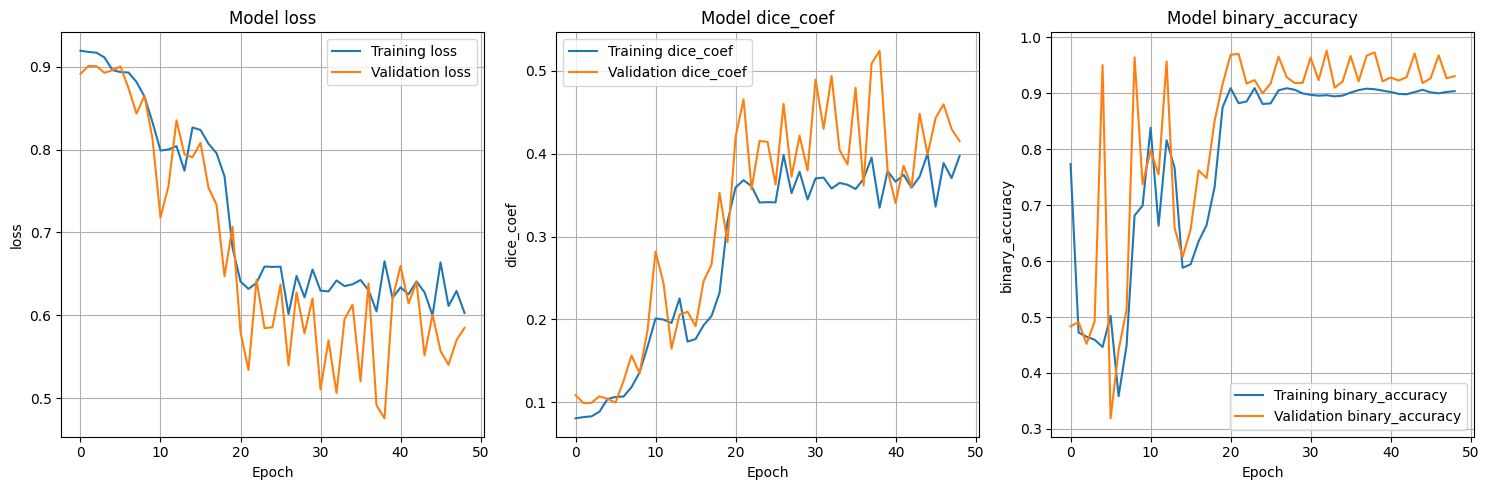

In [62]:
def plot_training_history(history):
    """
    Plot training and validation metrics from model training history
    """
    metrics = ['loss', 'dice_coef', 'binary_accuracy']  # Add other metrics if needed

    plt.figure(figsize=(15, 5))

    for i, metric in enumerate(metrics):
        # Skip if metric wasn't tracked
        if metric not in history.history:
            continue

        plt.subplot(1, len(metrics), i+1)

        # Plot training metric
        plt.plot(history.history[metric], label=f'Training {metric}')

        # Plot validation metric if it exists
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')

        plt.title(f'Model {metric}')
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# After model training, call the plotting function
plot_training_history(history)

In [64]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import warnings

# Suppress the specific warning
warnings.filterwarnings("ignore", category=UserWarning, module="absl")

# Define your custom metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Load model with custom objects and compile it
try:
    model = load_model('liver_tumor_segmentation.h5',
                     custom_objects={'dice_coef': dice_coef, 'dice_loss': dice_loss})

    # Recompile to build metrics
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss=dice_loss,
                metrics=[dice_coef, 'binary_accuracy'])

    print("Model loaded and compiled successfully")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded and compiled successfully


FileUpload(value={'ctctc.jpg': {'metadata': {'name': 'ctctc.jpg', 'type': 'image/jpeg', 'size': 129543, 'lastM…

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


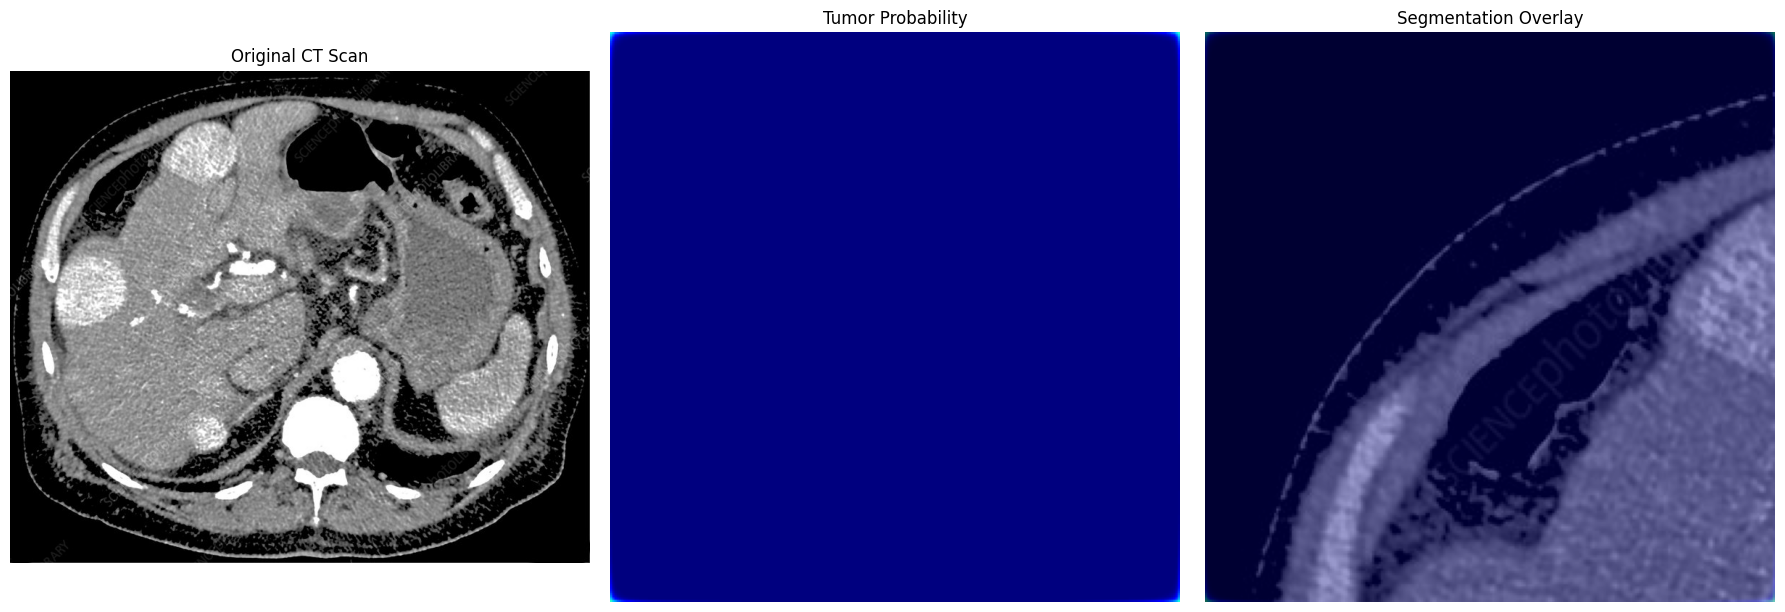

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import display, clear_output
import ipywidgets as widgets

def preprocess_image(image, target_size=(256, 256)):
    """Preprocess uploaded image for model prediction"""
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image.astype(np.float32)
    image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)
    image = cv2.resize(image, target_size)
    return np.expand_dims(image, axis=-1)

def predict_and_display(image):
    """Display original image and segmentation prediction"""
    processed_img = preprocess_image(image)
    pred_mask = model.predict(np.expand_dims(processed_img, axis=0))[0]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Original image
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Original CT Scan')
    ax1.axis('off')

    # Predicted mask
    ax2.imshow(pred_mask[:, :, 0], cmap='jet', vmin=0, vmax=1)
    ax2.set_title('Tumor Probability')
    ax2.axis('off')

    # Overlay
    ax3.imshow(image, cmap='gray')
    ax3.imshow(pred_mask[:, :, 0], cmap='jet', alpha=0.4, vmin=0, vmax=1)
    ax3.set_title('Segmentation Overlay')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

def handle_upload(change):
    """Handle image upload"""
    # Get the uploaded file (check format)
    if isinstance(change.new, dict):
        uploaded_file = next(iter(change.new.values()))
    else:  # Assuming it's a list of dicts
        uploaded_file = change.new[0]  # Get the first uploaded file

    # Access file content based on format
    if 'content' in uploaded_file:
        content = uploaded_file['content']
    else:  # If 'content' is not available, try alternative access
        content = uploaded_file.get('data', None) # For some FileUpload formats
        if content is None:
            raise ValueError("Error: Cannot get file content using 'content' or 'data' key.")

    # ... rest of your function ...

    nparr = np.frombuffer(content, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    clear_output()
    display(upload_button)
    predict_and_display(img)

# Create upload widget
upload_button = widgets.FileUpload(
    accept='.png,.jpg,.jpeg,.nii,.dcm',
    multiple=False,
    description='Upload CT Scan'
)
upload_button.observe(handle_upload, names='value')

display(upload_button)